<a href="https://colab.research.google.com/github/spacemaninSeoul/PythonMachinelearningGuide/blob/main/%5B%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C%5D_III_%ED%8F%89%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

머신러닝은 데이터 가공/변환, 모델 학습/예측, 그리고 평가(Evaluation)의 프로세스로 구성된다.

머신러닝 모델에서는 여러 가지 방법으로 예측 성능을 평가할 수 있다. 성능 평가 지표(Evaluation Metrics)는 일반적으로 모델이 분류나 회귀냐에 따라 여러 종류로 나뉜다.

먼저 분류의 성능 평가 지표는 다음과 같다.

* 정확도(Accuracy)
* 오차행렬(Confusion Matrix)
* 정밀도(Precision)
* 재현율(Recall)
* F1 스코어
* ROC AUC

분류는 결정 클래스값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 이진 분류와 여러 개의 결정 클래스 값을 가지는 멀티 분류로 나눌 수 있다.

# 1. 정확도(Accuracy)

정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표이다.

> 정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않는다.

특히나 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아니다.

MNIST 데이터 세트를 변홚 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴보도록 한다.

**MNIST** 데이터 세트는 0부터 9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit을 예측하는 데 사용된다. 사이킷런은 load_digits( ) API를 통해 MNIST 데이터 세트를 제공한다.

원래 MNIST 데이터 세트는 레이블 값이 0부터 9까지 있는 멀티 레이블 분류를 위한 것이다. 이것을 레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 바꿔 본다. 즉, 전체 데이터의 10%만 True, 나머지는 90%는 False인 불균형한 데이터 세트로 변형하는 것이다.

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

class MyFakeClassifier(BaseEstimator):
  def fit(self, X, y):
    pass

  # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

# 사이킷런의 내장 데이터 세트인 load_digits( )을 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [2]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 데이터 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classfier로 학습/예측/정확도평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 데이터 세트 크기 : (450,)
테스트 세트 레이블 0 과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여 정확도는:0.900


단순히 predict( )의 결과를 np.zeros( )로 모두 0 값으로 반환함에도 불구하고 450개의 테스트 데이터 세트에 수행한 예측 정확도는 90%이다.

이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능 수치로 사용돼서는 안 된다. 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 한다. 먼저 오차 행렬을 설명하도록 한다.

# 2. 오차 행렬

이진 분류에서 성능 지표로 잘 활용되는 **오차행렬(confusion matrix, 혼동행렬)**은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표이다. 즉, 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타내는 지표이다.

* TN은 예측값을 Negative 값 0으로 예측했고, 실제 값 역시 Negative 값 0
* FP는 예측값을 Positive 값 1로 예측했는데, 실제 값은 Negative 값 0
* FN은 예측값을 Negative 값 0으로 예측했는데, 실제 값은 Positive 값 1
* TP 예측값을 Postitive 값 1로 예측했는데, 실제 값 역시 Positive 값 1

사이킷런은 오차 행렬을 구하기 위해 confusion_matrix( ) API를 제공한다.

In [3]:
# MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 confusion_matrix()의 인자로 입력해 오차 행렬 확인
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]])

순서대로 TN, FP, FN, FP에 해당

앞에서도 소개한 정확도는 예측값과 실제 값이 얼마나 동일한가에 대한 비유롤 결정. 즉, 오차 행렬에서 True에 해당하는 값인 TN와 TP에 좌우 된다.
> 정확도 = 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 수 = (TN + TP)/(TN + FP + FN + TP)

결과적으로 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으키게 된다.

# 3. 정밀도와 재현율

**정밀도**는 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다.
> 정밀도 = TP / (FP + TP)

**재현율**은 실제 값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율을 뜻한다.
> 재현율 = TP / (FN + TP)


*   재현율이 상대적으로 더 중요한 지표는 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 ex) 암 판단 모델, 금융 사기 적발 모델
*   정밀도가 상대적으로 더 중요한 지표인 경우 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 ex) 스팸메일 여부 판단 모델

재현율과 정밀도의 공식을 살펴보았을 때, 재현율과 정밀도 모두 TP를 높이는 데 동일하게 초점을 맞추지만, 재현율은 FN(실제 Positive, 예측 Negative)를 낮추는 데, 정밀도는 FP를 낮추는 데 초점을 맞춘다.

이 같은 특성 때문에 재현율과 정밀도는 서로 보완적인 지표로 분류의 성능을 평가하는 데 적용된다. 가장 좋은 성능 평가는 재현율과 정밀도 모두 높은 수치를 얻는 것이다.



사이킷런은 정밀도 계산을 위해 **precision_score( )**를, 재현율 계산을 위해 **recall_score( )**를 API로 제공한다.

평가를 간편하게 적용하기 위해서 confusion matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval( ) 함수를 만들도록 한다.

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1: .4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

In [6]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고 평가를 수행한다.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('/content/drive/MyDrive/데이터분석/파이썬머신러닝완벽가이드/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:  0.7742, 재현율: 0.7869


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 1) 정밀도/재현율 트레이드오프

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다. 하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉽다. 이를 **정밀도/재현율의 트레이드오프(Trade-off)라고 부른다**.


사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba( )를 제공한다.
**predict_proba( )** 메서드는 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하며 테스트 피처 데이터 세트를 파라미터로 입력해주면 테스트 피처 레코드의 개별 클래스 예측 확률을 반환한다. predict( ) 메서드와 유사하지만 단지 반환 결과가 예측 결과 클래스 값이 아닌 예측 확률 결과이다.



*   입력 파라미터 : predict( ) 메서드와 동일하게 보통 테스트 피처 데이터 세트 입력
*   반환 값 : 개별 클래스의 예측 확률을 ndarray m x n (m: 입력 값의 레코드 수, n: 클래스 값 유형) 형태로 반환. 입력 테스트 데이터 세트의 표본 개수가 100개이고 예측 클래스 값 유형이 2개(이진 분류)라면 반환 값은 100 x 2 ndarray 이다. 또한 각 열은 개별 클래스의 예측 확률이다 첫 번째 칼럼은 0 Negative의 확률, 두 번째 칼럼은 1 Positive 확률이다.

이진 분류에서 predict_proba( )를 수행해 반환되는 ndarray는 첫 번째 칼럼이 클래스 값 0에 대한 예측 확률, 두 번째 칼럼이 클래스 값 1에 대한 예측 확률이다.




In [7]:
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba( ) 결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확룰과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba( ) 결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46161641 0.53838359]
 [0.87858964 0.12141036]
 [0.87724119 0.12275881]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46161641 0.53838359 1.        ]
 [0.87858964 0.12141036 0.        ]
 [0.87724119 0.12275881 0.        ]]


사실 predict( ) 메서드는 predict_proba( ) 메서드에 기반해 생성된 API이다. predict( )는 predict_proba( ) 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치(첫 번째 칼럼 또는 두 번째 칼럼)를 받아서 최종적으로 예측 클래스를 결정하는 API이다.

사이킷런의 predict( )는 predict_proba( ) 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값(바로 앞에서는 0.5였음) 만족하는 ndarray의 칼럼 위치를 최종 예측 클래스로 결정한다고 했다. 이러한 구현을 위해 사이킷런의 Binarizer 클래스를 이용한다. 먼저 Binarizer 클래스의 사용법을 알아보도록 한다.

다음 예제에서는 threshold 변수를 특정 값으로 설정하고 Binarizer 클래스로 객체로 생성한다. 생성된 Binarizer 객체의 fit_transform( ) 메서드를 이용해 넘파이 ndarray를 입력하면 입력된 ndarray의 값을 지정된 threshold보다 같거나 작으면 0값으로, 크면 1값으로 변환해 반환한다.

In [10]:
from sklearn.preprocessing import Binarizer

X =  [[1, -1, 2],
      [2, 0, 0],
      [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환한다.
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [14]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba( ) 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)
#binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
#custom_predict = (binarizer.transform(pred_proba_1))

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:  0.7742, 재현율: 0.7869


분류 결정 임곗값을 낮추면 평가 지표가 어떻게 될지 확인하도록 한다.

In [15]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold)
custom_predict = binarizer.fit_transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도:  0.7286, 재현율: 0.8361


임곗값을 낮추니 재현율 값(TP/FN + TP)이 올라가고 정밀도(TP/FP + TP)가 떨어졌다. 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 되는데, 확률이 0.5가 아닌 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 임곗값 값을 낮출수록 True 값이 많아지게 된다.

이번에는 임곗값을 0.4에서부터 0.6까지 0.05씩 증가시키며 평가 지표를 조사한다. 이를 위해 get_eval_by_threshold( ) 함수를 만든다.

In [16]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_1, thresholds):
  # threshold list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold=custom_threshold)
    custom_predict = binarizer.fit_transform(pred_proba_1)
    print('임곗값:', custom_threshold)
    get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도:  0.7286, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도:  0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:  0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도:  0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도:  0.8824, 재현율: 0.7377


위에서 임곗값 변화에 따른 평가 지표 값을 알아보는 코드를 작성했는데, 사이킷런은 이와 유사한 precision_recall_curve( ) API를 제공한다. precision_recall_curve( ) API의 입력 파라미터와 반환 값은 다음과 같다.

*   입력 파라미터 - **y_true** : 실제 클래스값 배열 ( 배열 크기 = [데이터 건수] ), **probas_pred** : Positive 칼럼의 예측 확률 배열 ( 배열 크기 = [데이터 건수] )
*   반환 값 - **정밀도** : 임곗값별 정밀도 값을 배열로 반환, **재현율** : 임곗값별 재현율 값을 배열로 반환



precision_recall_curve( )를 이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율을 구해 보도록 한다. precision_recall_curve( )의 인자로 실제 값 데이터 세트와 레이블 값이 1일 때의 예측 확률 값을 입력한다.

In [19]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1= lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환 된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환 된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


precision_recall_curve( ) API를 이용한 정밀도와 재현율의 임곘값에 따른 값 변화 시각화

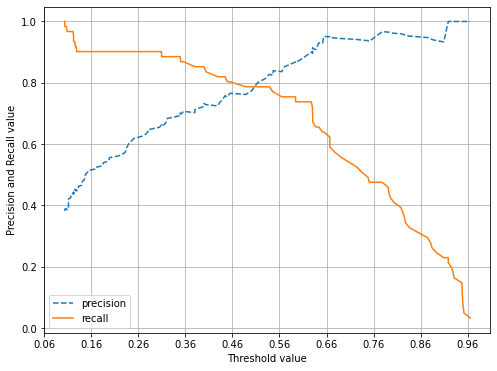

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
  precisions, recall, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold 값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X 축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # X축, Y축 label과 lend, 그리고 grid 설정
  plt.xlabel('Threshold value'); plt. ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임곗값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상이 된다.

# 4. F1 스코어

**F1 스코어(Score)**는 정밀도와 재현율을 결합한 지표이다. F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

>F1 = 2 / (1/recall) + (1/precision) = 2 * (precision * recall) / (precision + recall)

사이킷런은 F1 스코어를 구하기 위해 **f1_scrore( )**라는 API를 제공한다.

In [24]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


이번엔 타이타닉 생존자 예측에서 임곗값을 변화시키며 F1 스코어를 포함한 평가 지표를 구해 보도록 한다.

In [25]:
def get_clf_eval(y_test, pred):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  # F1 스코어 추가
  f1 = f1_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  # f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율: 0.8361, F1:0.7786
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율: 0.8033, F1:0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율: 0.7869, F1:0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율: 0.7541, F1:0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율: 0.7377, F1:0.8036


# 5. ROC 곡선과 AUC

ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.

**ROC 곡선**은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변하는지를 나타내는 곡선이다. FPR을 X축으로, TPR을 Y축으로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.

TPR은 재현율을 나타낸다. 따라서 TPR = TP / (FN + TP)이다. TPR은 민감도로도 불린다.

민감도에 대응하는 지표로 TNR(True Negative Rate)이라고 불리는 특이성(Specificity)이 있다.

* **민감도(TPR)**은 실제값 Positive(양성)가 정확히 예측돼야 하는 수준을 나타낸다(질병이 있는 사람을 질병이 있는 것으로 양성 판정).

* **특이성(TNR)**은 실제값 Negative(음성)가 정확히 예측돼야 하는 수준을 나타낸다(질병이 없는 건강한 사람은 질병이 없는 것으로 음성 판정)

TNR인 특이성은 다음과 같이 구할 수 있다. TNR  = TN / ( FP + TN ). 그리고 ROC 곡선의 X 축 기준인 FPR(False Positive Rate)은 FP / ( FP + TN ) 이므로 1 - TNR 또는 1 - 특이성으로 표현된다.

> FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성

ROC 곡선이 가운데 직선에 가까울수록 성능이 떨어지는 것이며, 멀어질수록 성능이 뛰어난 것이다.

ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화 값을 구한다. FRP 값은 분류 결정 임곗값을 변경하면서 변경할 수 있다. 분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이기 때문에 FPR을 0으로 만드려면 임곗값을 1로 지정하면 된다.

이렇게 임곗값을 1부터 0까지 변화시키면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR 값을 구하는 것이 ROC 곡선이다.

사이킷런은 ROC 곡선을 구하기 위해 roc_curve( ) API를 제공한다.


*   입력 파라미터 - **y_true**: 실제 클래스 값 array ( array shape = [데이터 건수] ), **y_score** : predict_proba( )의 반환 값 array에서 Positive 칼럼의 예측 확률이 보통 사용된다. array shape = [n_samples]
*   반환 값 - **fpr**: fpr 값을 array로 반환, **tpr**: tpr 값을 array로 반환, **thresholds**: threshold 값 array



In [27]:
from sklearn.metrics import roc_curve
# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_1)
# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR:  [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


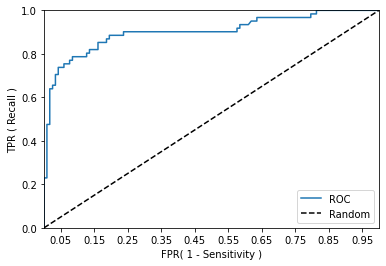

In [29]:
# FPR의 변화에 따른 TPR의 변화 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
  # 임곗값에 따른 FPR, TPR 값을 반환받음
  fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
  # ROC 곡선을 그래프 곡선으로 그림.
  plt.plot(fprs, tprs, label = 'ROC')
  # 가운데 대각선 직선을 그림
  plt.plot([0, 1], [0, 1], 'k--', label = 'Random')

  # FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))
  plt.xlim(0, 1); plt.ylim(0, 1)
  plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR ( Recall )')
  plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다. AUC(Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로서 일반적으로 1에 가까울수록 좋은 수치이다. AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 TPR을 얻을 수 있느냐가 관건이다.

In [31]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [33]:
# 정확도, 정밀도, 재현율, F1 스코어, ROC AuC 값을 출력하는 get_clf_eval( ) 함수 정의

def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  # ROC-AUC 추가
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  # ROC_AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 6. 피마 인디언 당뇨병 예측